# Lecture 9: From dense to sparse linear algebra

## Recap of the previous lecture
- Algorithms for the symmetric eigenvalue problems (QR-algorithm, Divide-and-Conquer, bisection)
- SVD and its applications (collaborative filtering, integral equations, latent semantic indexing)


## Interesting fact 1

Before $$A_k = Q_k R_k, \quad A_k = R_k Q_k$$, 

there was $LU-UL$ algorithm by [Heinz Rutishauser](https://en.wikipedia.org/wiki/Heinz_Rutishauser)

$$A_k = L_k U_k, \quad A_{k+1} = U_k L_k.$$

This generates a sequence of similar matrices, but is less stable than QR algorithm.

Int. fact: Heinz Rutishauser has proposed the **for** keyword in programming language.

## Interesting fact 2

Recent paper [Strassen algorithm reloaded](http://delivery.acm.org/10.1145/3020000/3014983/a59-huang.pdf?ip=89.106.174.124&id=3014983&acc=OPEN&key=4D4702B0C3E38B35%2E4D4702B0C3E38B35%2E4D4702B0C3E38B35%2E6D218144511F3437&CFID=850797828&CFTOKEN=25065737&__acm__=1479192384_96a207c8760b13d6521f71b8bbc370f0)

claim to **break conventional wisdom**



## Strassen reloaded
We dispel with “street wisdom” regarding the
practical implementation of Strassen’s algorithm for matrixmatrix
multiplication (DGEMM). 

- Conventional wisdom: it is only
 practical for very large matrices. Our implementation is practical
 for small matrices. 
- Conventional wisdom: the matrices being
 multiplied should be relatively square. Our implementation is
 practical for rank-k updates, where k is relatively small (a shape
 of importance for libraries like LAPACK). 
- Conventional wisdom:
  it inherently requires substantial workspace. Our implementation
  requires no workspace beyond buffers already incorporated
  into conventional high-performance DGEMM implementations.
- Conventional wisdom: a Strassen DGEMM interface must pass
 in workspace. Our implementation requires no such workspace
 and can be plug-compatible with the standard DGEMM interface.
- Conventional wisdom: it is hard to demonstrate speedup
 on multi-core architectures. Our implementation demonstrates
 speedup over conventional DGEMM even on an IntelR Xeon
 PhiTM coprocessor utilizing 240 threads. We show how a distributed
 memory matrix-matrix multiplication also benefits from
 these advances.

## Sparse matrices 

For dense linear algebra problems, we are limited by the memory to store the full matrix, it is $N^2$ parameters.

If we want to go to larger $N$, we have to store the matrix.

The class of **sparse** matrices where most of the elements are zero, allows us **at least** to store such matrices.

The question if we can:

- Solve linear systems
- Solve eigenvalue problems

with such matrices. 

## Today lecture

Today we will talk about **sparse matrices**, where they arise, how we store them, how we operate with them.


- Formats: list of lists and compressed sparse row format, relation to graphs
- Fast matrix-by-vector product
- Fast direct solvers for Gaussian elimination


## Applications of sparse matrices

Sparse matrices appear: 

- In Partial Differential Equations (PDE), mathematical modelling
- In graphs mining (social networks)
- In recommender systems
- Everywhere when there are relations between objects is "sparse".

## Sparse matrices are ubiqitous in PDE
Consider the simplest partial differential equation (PDE), called **Laplace equation**:  
$$
   \Delta T = \frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y^2} = f.
$$

## Discretization
$$\frac{\partial^2 T}{\partial x^2} \approx \frac{T(x+h) + T(x-h) - 2T(x)}{h^2} + \mathcal{O}(h^4),$$
same for $\frac{\partial^2 T}{\partial y^2},$
and we get a linear system.  
    First, let us do **one-dimensional case**:

After the discretization of the one-dimensional Laplace equation with Dirichlet boundary conditions we have
$$\frac{u_{i+1} + u_{i-1} - 2u_i}{h^2} = f_i,$$

or in the matrix form

$$
   A u = f,
$$
                   and ($n = 5$ illustration)
\begin{equation}
A=-\frac{1}{h^2}\begin{bmatrix}
   2& -1 & 0 & 0 & 0\\
   -1 & 2 & -1 & 0 &0 \\
   0 & -1 & 2& -1 & 0 \\
   0 & 0 & -1 & 2  &-1\\
   0 & 0 & 0 & -1 & 2
   \end{bmatrix}
   \end{equation}

The matrix is **triadiagonal** and **sparse**  
(and also **Toeplitz**: all elements on the diagonal are the same)

## Block structure in 2D
In two dimensions, we get equation of the form  
$$\frac{4u_{ij} -u_{(i-1)j} - u_{(i+1)j} - u_{i(j-1)}-u_{i(j+1)}}{h^2} = f_{ij},$$

or in the **Kronecker product form**  

$$\Delta_2 = \Delta_1 \otimes I + I \otimes \Delta_1,$$

where $\Delta_1$ is a 1D Laplacian, and $\otimes$ is a **Kronecker product** of matrices. 

For matrices $A$ and $B$ its Kronecker product is defined as a block matrix of the form 
$$
   [a_{ij} B]
$$

In the block matrix form the 2D-Laplace matrix can be written in the following form:  

$$
   A = -\frac{1}{h^2}\begin{bmatrix}
   \Delta_1 + 2I & -I & 0 & 0 & 0\\
   -I & \Delta_1 + 2I  & -I & 0 &0 \\
   0 & -I & \Delta_1 + 2I & -I & 0 \\
   0 & 0 & -I & \Delta_1 + 2I   &-I\\
   0 & 0 & 0 & -I & \Delta_1 + 2I 
   \end{bmatrix}
$$

## Sparse matrix.

We can create this matrix using **scipy.sparse** package (actually this is **not the best** sparse matrix package)

We can go to really large sizes (at least, to store this matrix in the memory).

We have "sparse tridiagonal matrix" in scipy, we have Kronecker product overloaded, we have sparse matrix as an output.

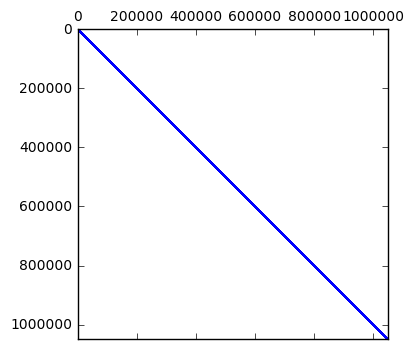

In [2]:
import numpy as np
import scipy as sp
import scipy.sparse
from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt
%matplotlib inline
n = 1024
ex = np.ones(n);
lp1 = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
e = sp.sparse.eye(n)
A = sp.sparse.kron(lp1, e) + sp.sparse.kron(e, lp1)
A = csc_matrix(A)
plt.spy(A, aspect='equal', marker='.', markersize=1)

## Sparsity pattern 

The ``spy`` command plots the sparsity pattern of the matrix: the $(i, j)$ pixel is drawn, if the corresponding matrix element is non-zero.

Sparsity pattern is really important for the understanding the complexity of the sparse linear algebra algorithms.  

Often, only the sparsity pattern is needed for the analysis of "how complex" the matrix is.

## Sparse matrix: formal definition

The formal definition of "sparse matrix" is that the number of **non-zero elements** is much less than the total number of

elements, so you can do the basic linear algebra operations (like solving linear systems at the first place) can be done faster, 

than if working for with the full matrix.

The **scipy.sparse** package has tools for solving sparse linear systems:

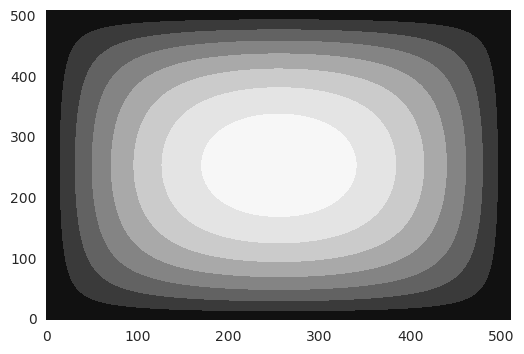

In [10]:
import numpy as np
import scipy as sp
import scipy.sparse
import scipy.sparse.linalg
import seaborn as sns
from scipy.sparse import csc_matrix, csr_matrix
import matplotlib.pyplot as plt
%matplotlib inline
n = 512
ex = np.ones(n);
lp1 = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
e = sp.sparse.eye(n)
A = sp.sparse.kron(lp1, e) + sp.sparse.kron(e, lp1)
A = csr_matrix(A)
rhs = np.ones(n * n)
sol = sp.sparse.linalg.spsolve(A, rhs)
#plt.plot(sol)
plt.contourf(sol.reshape((n, n)))

## What we need to find out to see how it actually works

**Question 1:** How to store the sparse matrix in memory?

**Question 2:** How to multiply sparse matrix by vector fast?

**Question 3:** How to solve linear systems with sparse matrices fast?



## Sparse matrix storage

There are many of those, important ones:

- COO (Coordinate format)
- LIL (Lists of lists)
- CSR (compressed sparse row)
- CSC (compressed sparse column)
- Block variants

## Coordinate format

The simplest format is to use **coordinate format** to represent the sparse matrix as positions and values of non-zero elements.

``python
i, j, val
``

where i, j are integer array, val is the real array.

**Q:** What is good and what is bad for this format?

## Main disadvantage

- It is not optimal in storage (why?)
- It is not optimal for matrix-by-vector product (why?)
- It is not optimal for adding/removing elements (this is good in LIL format)

This is solved by **compressed sparse row** (CSR) format.

## Compressed sparse row (CSR)

In the CSR format a matrix is stored as 3 different arrays: 
```python
ia, ja, sa
```
where:

- **ia** is an integer array of length $n+1$ 
- **ja** is an integer array of length **nnz** 
-  **sa** is an real-value array of length **nnz**
- **nnz** is the total number of non-zeros for the matrix


## Idea behind CSR.
- For each row $i$ we store the column number of the non-zeros (and their) values
- We stack this all together into **ja** and **sa** arrays
- We save the location of the **first non-zero element** in each row

## CSR helps for matrix-by-vector product as well
```python
   for i in range(n):
       for k in range(ia[i]:ia[i+1]):
           y[i] += sa[k] * x[ja[k]]
```

Let us do a short timing test

In [11]:
import numpy as np
import scipy as sp
import scipy.sparse
import scipy.sparse.linalg
from scipy.sparse import csc_matrix, csr_matrix, coo_matrix
import matplotlib.pyplot as plt
%matplotlib inline
n = 60
ex = np.ones(n);
lp1 = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
e = sp.sparse.eye(n)
A = sp.sparse.kron(lp1, e) + sp.sparse.kron(e, lp1)
A = csr_matrix(A)
rhs = np.ones(n * n)
B = coo_matrix(A)
%timeit A.dot(rhs)
%timeit B.dot(rhs)

The slowest run took 9.96 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 46.6 µs per loop
The slowest run took 26.95 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 70.6 µs per loop


As you see, **CSR** is faster, and for more **unstructured patterns** the gain will be larger.

## Sparse matrices and efficiency
Sparse matrix give complexity reduction.  

But they are **not very good** for parallel/GPU implementation.  

And they do not give maximal efficiency due to **random data access**.  

Typically, peak efficiency of $10\%-15\%$ is considered good.  

## Recall how we measure efficiency of linear algebra operations

The standard way to measure the efficiency of linear algebra operations on a particular computing architecture is to 

use **flops** (number of floating point operations per second)

The peak performance is determined as 

 **frequency x number of cores x pipeline size x 2**

We can measure peak efficiency of an ordinary matrix-by-vector product.

In [12]:
import numpy as np
import time
n = 4000
a = np.random.randn(n, n)
v = np.random.randn(n)
t = time.time()
np.dot(a, v)
t = time.time() - t
print('Time: {0: 3.1e}, Efficiency: {1: 3.1e} Gflops'.\
      format(t,  ((2 * n ** 2)/t) / 10 ** 9))

Time:  7.4e-03, Efficiency:  4.3e+00 Gflops


In [13]:
n = 4000
ex = np.ones(n);
a = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
rhs = np.random.randn(n)
t = time.time()
a.dot(rhs)
t = time.time() - t
print('Time: {0: 3.1e}, Efficiency: {1: 3.1e} Gflops'.\
      format(t,  (3 * n) / t / 10 ** 9))

Time:  2.0e-04, Efficiency:  5.9e-02 Gflops


## How to make things more efficient

Sparse matrix computations dominate the linear algebra computations nowdays.

They allow us to work with much larger matrices, but they utilize only $10\%-15\%$ percent of the peak computer performance.

It means, that our computer architecture **is not well suited** for standard sparse matrix algorithms.

There are many possible solutions of the problem, for example:

1. Use block sparse format
2. Reorder equations to make them more "block"
3. Instead of vectors, use "block vectors"

In [23]:

n = 10000
k = 10
ex = np.ones(n);
a = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
rhs = np.random.randn(*(n, k))
t = time.time()
a.dot(rhs)
t = time.time() - t
print('Time: {0: 3.1e}, Efficiency: {1: 3.1e} Gflops'.\
      format(t,  (3 * n * k) / t / 10 ** 9))

Time:  1.0e-03, Efficiency:  2.9e-01 Gflops


## Florida sparse matrix collection

There are many other types of matrices besides tridiagonal/block tridiagonal

[Florida sparse matrix collection](http://www.cise.ufl.edu/research/sparse/matrices/) which contains all sorts of matrices for different applications.

It also allows for finding test matrices as well! 

We can have a look.

In [24]:
from IPython.display import HTML
HTML('<iframe src=http://yifanhu.net/GALLERY/GRAPHS/search.html width=700 height=450></iframe>')


## Visualization of sparse matrices and graph

Sparse matrices and fast algorithms (especially for linear systems) have deep connection with graph theory.

First of all, sparse matrix can be treated as an **adjacency matrix** of a certain graph:

The vertices $(i, j)$ are connected, if the corresponding matrix element is non-zero.

The graph can be undirected (if the matrix is symmetric), and is directed otherwise.

## Graph structure is important for LU decomposition

Why sparse linear systems can be solved faster, what is the technique? 

In the LU-factorization of the matrix $A$ the factors $L$ and $U$ can be also sparse:

$$A = L U$$

And solving linear systems with **sparse** triangular matrices is very easy.  

<font color='red'> Note that the inverse matrix is not sparse! </font>


In [3]:
#Indeed, it is not sparse
n = 7
ex = np.ones(n);
a = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
a = a.todense()
b = np.array(np.linalg.inv(a))
print a
print b

[[-2.  1.  0.  0.  0.  0.  0.]
 [ 1. -2.  1.  0.  0.  0.  0.]
 [ 0.  1. -2.  1.  0.  0.  0.]
 [ 0.  0.  1. -2.  1.  0.  0.]
 [ 0.  0.  0.  1. -2.  1.  0.]
 [ 0.  0.  0.  0.  1. -2.  1.]
 [ 0.  0.  0.  0.  0.  1. -2.]]
[[-0.875 -0.75  -0.625 -0.5   -0.375 -0.25  -0.125]
 [-0.75  -1.5   -1.25  -1.    -0.75  -0.5   -0.25 ]
 [-0.625 -1.25  -1.875 -1.5   -1.125 -0.75  -0.375]
 [-0.5   -1.    -1.5   -2.    -1.5   -1.    -0.5  ]
 [-0.375 -0.75  -1.125 -1.5   -1.875 -1.25  -0.625]
 [-0.25  -0.5   -0.75  -1.    -1.25  -1.5   -0.75 ]
 [-0.125 -0.25  -0.375 -0.5   -0.625 -0.75  -0.875]]


## And the factors...

$L$ and $U$ are typically much better. In the tridiagonal case they are even bidiagonal!

In [18]:
from scipy.sparse.linalg import splu
T=splu(a)
print T.L.todense()[-1, :]
print(T.perm_c)
#print l

[[ 0.          0.          0.          0.         -0.5        -0.71428571
   1.        ]]
[0 1 2 3 5 4 6]


## 2D-case
However, for a 2D case everything is much worser:

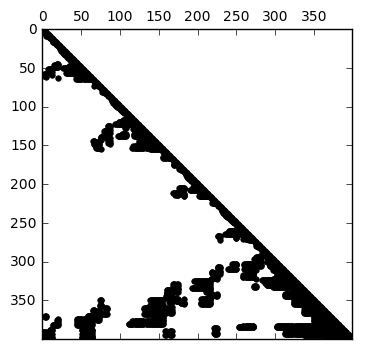

In [19]:
n = 20
ex = np.ones(n);
lp1 = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
e = sp.sparse.eye(n)
A = sp.sparse.kron(lp1, e) + sp.sparse.kron(e, lp1)
A = csc_matrix(A)
T = scipy.sparse.linalg.spilu(A)
plt.spy(T.L, marker='.', color='k', markersize=8)

For two-dimensional case the number of nonzeros in the L factor grows as $\mathcal{O}(N \log N)$. But  complexity is $\mathcal{O}(N^{3/2})$.

## Sparse matrices and graph ordering
The number of non-zeros in LU decomposition has a deep connection to the graph theory.

(I.e., there is an edge between $(i, j)$ if $a_{ij} \ne 0$.

``networkx package`` can be used to visualize graphs, given only the adjacency matrix. 

It may even recover to some extend the graph structure.

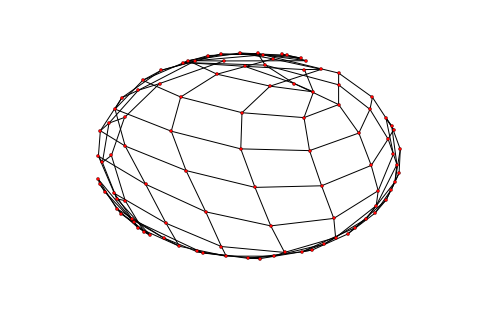

In [31]:
import networkx as nx
n = 10
ex = np.ones(n);
lp1 = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
e = sp.sparse.eye(n)
A = sp.sparse.kron(lp1, e) + sp.sparse.kron(e, lp1)
A = csc_matrix(A)
G = nx.Graph(A)
nx.draw(G, pos=nx.spring_layout(G), node_size=10)

## Fill-in minimization

Reordering the rows and the columns of the sparse matrix in order to reduce the number of non-zeros in $L$ and $U$ factors is called (**fill-in** minimization)  

is based on graph theory:


- **Minimum degree ordering** - order by the degree of the vertex
- **Cuthill–McKee algorithm** (and reverse Cuthill-McKee) -- order for a small bandwidth
- **Nested dissection**: split the graph into two with minimal number of vertices on the separator

## Take home message
- CSR format for storage
- Sparse matrices & graphs ordering
- Ordering is important for LU fill-in: more details on Thursday.

# Questions?

In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)
css_styling()